In [1]:
import sys
sys.path.append('../')
from src.utils.utils import get_sp500
from src.utils.utils import SP500ReturnSimulator

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 16]

SIMULATION_SIZE=50

# Get the data

Due to the limitation of the API, we are only able to retrieve the S&P500 index for the past 10 years.

In [2]:
sp500 = get_sp500(dropna=True)

In [3]:
sp500

DATE
2011-01-18    1295.02
2011-01-19    1281.92
2011-01-20    1280.26
2011-01-21    1283.35
2011-01-24    1290.84
               ...   
2021-01-11    3799.61
2021-01-12    3801.19
2021-01-13    3809.84
2021-01-14    3795.54
2021-01-15    3768.25
Name: sp500, Length: 2517, dtype: float64

<AxesSubplot:xlabel='DATE', ylabel='sp500'>

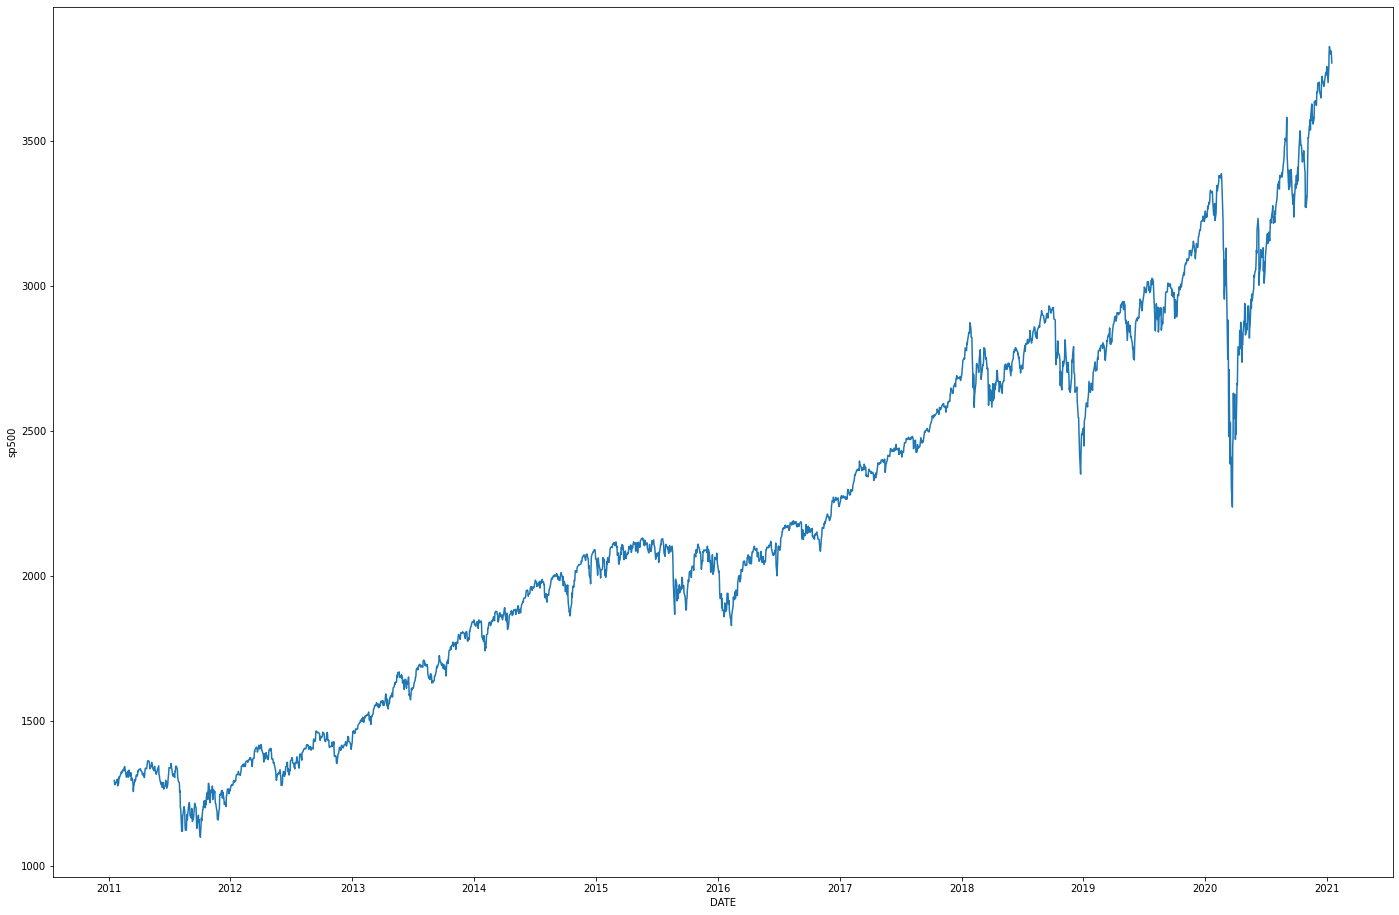

In [4]:
sns.lineplot(x='DATE', y='sp500', data=sp500.reset_index())

# Simulate return

We are assuming a buy only strategy on the S&P 500 and sell at the end of the time series (say retirement).


## Monthly buyer

The SP500ReturnSimulator has a few method to simulate the annualised return given various buying strategy given a buying frequency. Let's start by assuming that we only buy once a year so the number of purchase over the 10 years would be 10 * 12 or 120 times.

In [5]:
monthly_simulator = SP500ReturnSimulator(series=sp500, number_of_purchase=120)

### Best Case

The following graph shows the best 120 purchases over time. It is not the best 120 points to buy the stock as that would equate to buying all at the start of the time series. Rather, we split the time series into 120 chunks and find the best buying time in each of the period which resembles a consistent buying strategy.

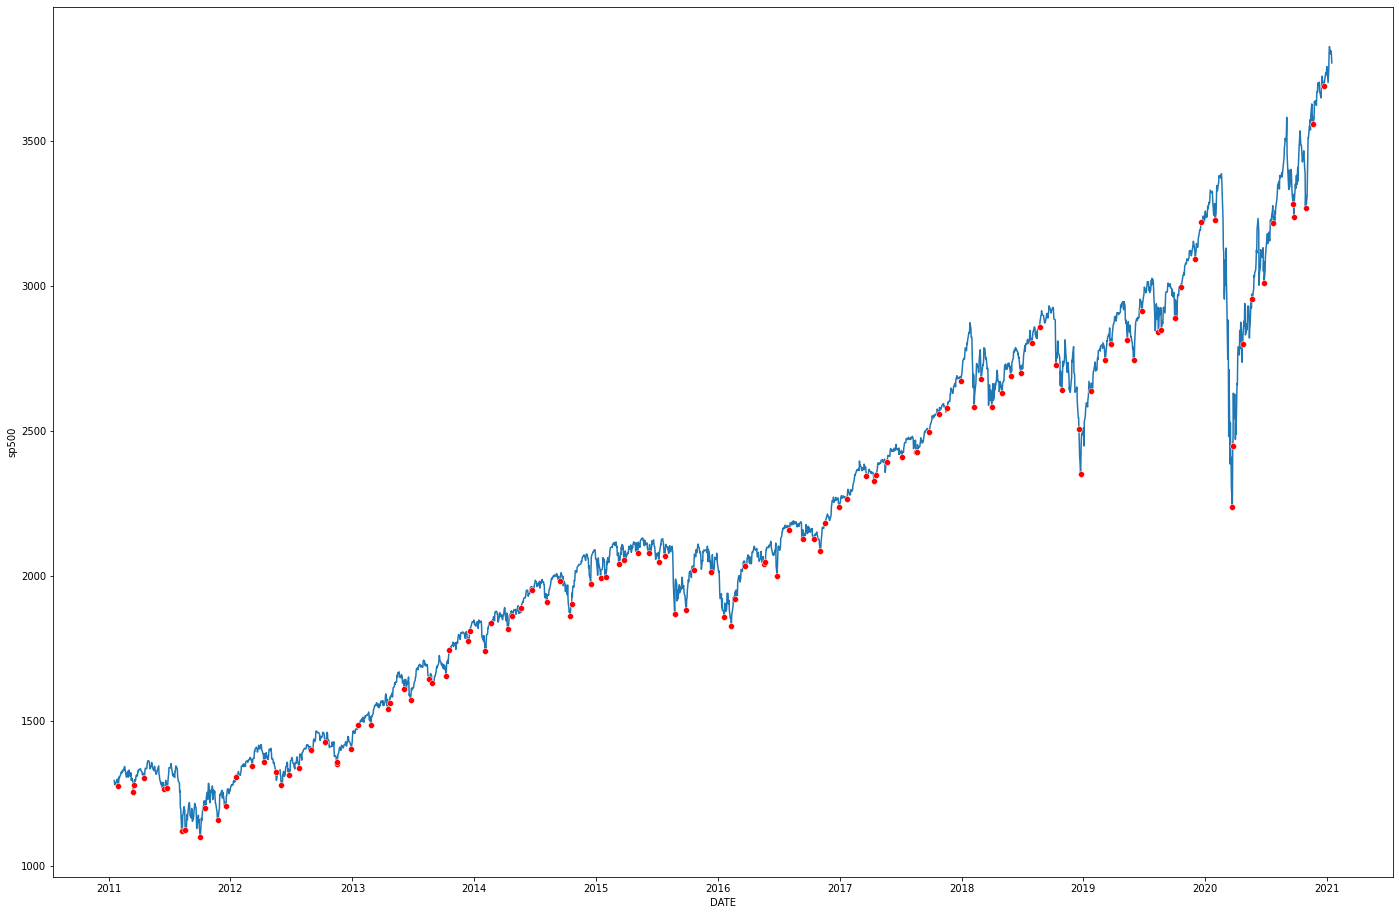

0.17535543917088067

In [6]:
monthly_simulator.optimal_return(plot=True)

### Worst case

On the other hand, the following is the reverse of the above which provide the return if all our buying timing were all at the worst time (highest point of the period).

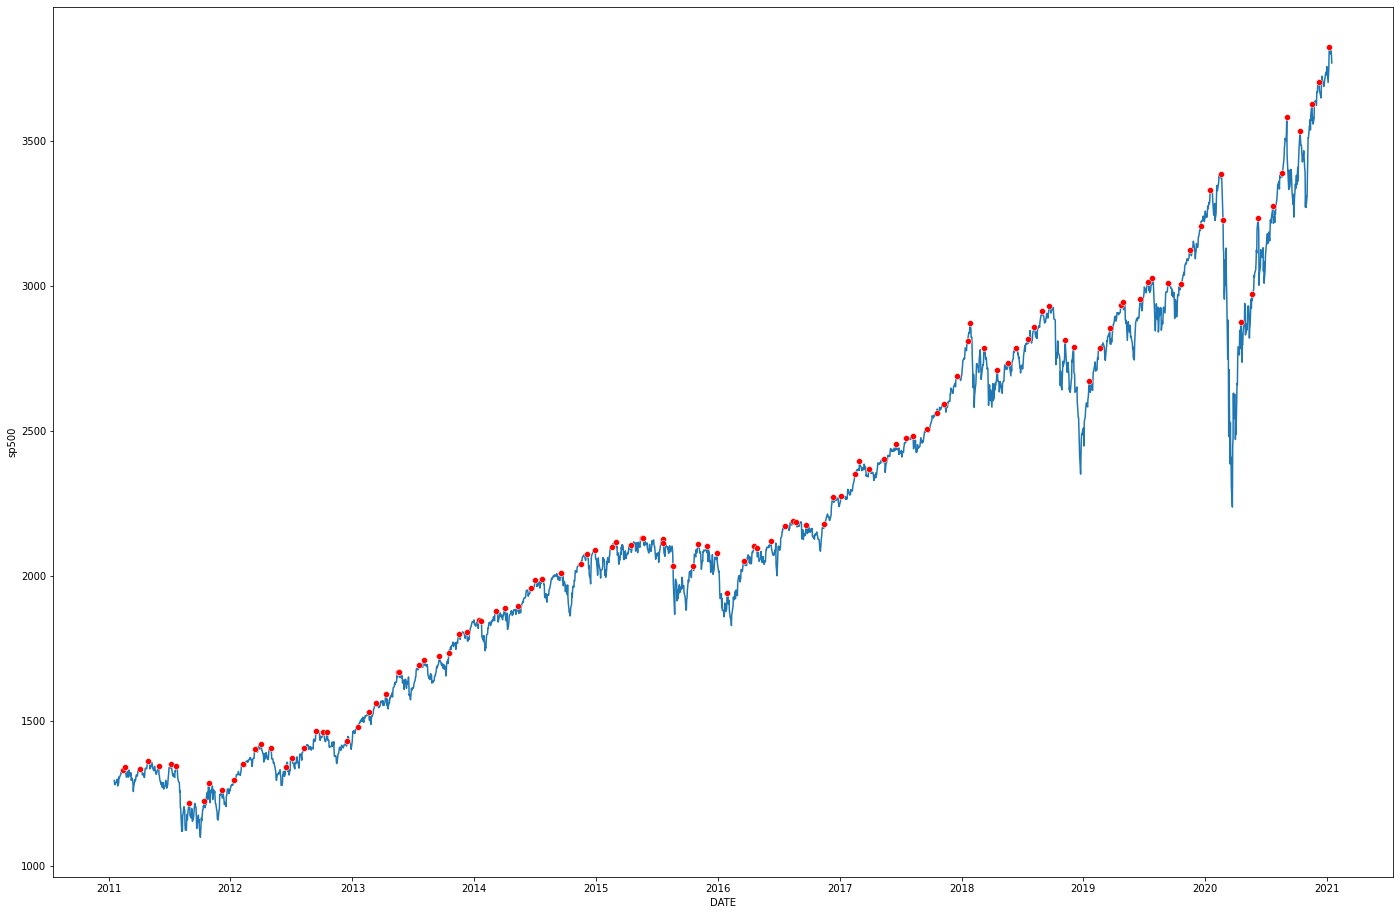

0.13265605931889135

In [7]:
monthly_simulator.worst_return(plot=True)

### Consistent Purchase

The consistent purchase is if we always buy say the first day of the period. Since this is not deterministic, we simulate 50 scenarios and then take the average.

In [8]:
monthly_simulator.random_sampling_strategy(plot=False, sample=SIMULATION_SIZE)

0.15159828102285777

### Random Purchase

In this case, we random pick a date within the period and makge a purchase, we also run 50 simulations.

In [9]:
monthly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE)

0.1521425790365838

The simulation shows that there are no difference in the expected return between consistent or random purchase. There is a marginal gap between them and the optimal value, but the size isn't large given the number of correct guesses required.

## Annual Buyer

Let's change the frequency of buying and then see whether the return changes.

In [10]:
annual_simulator = SP500ReturnSimulator(series=sp500, number_of_purchase=10)

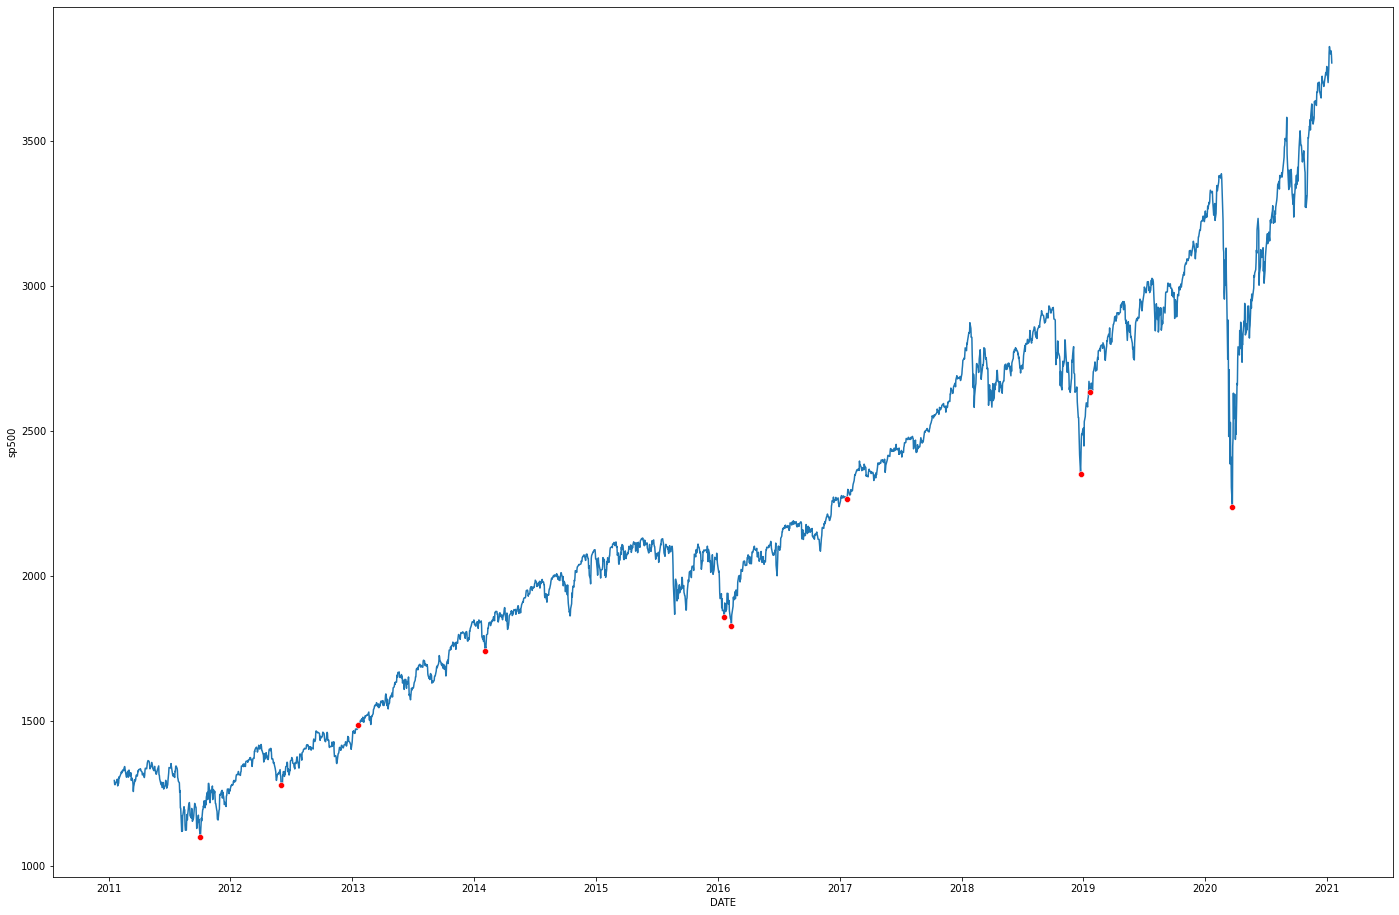

0.2285359662937574

In [11]:
annual_simulator.optimal_return(plot=True)

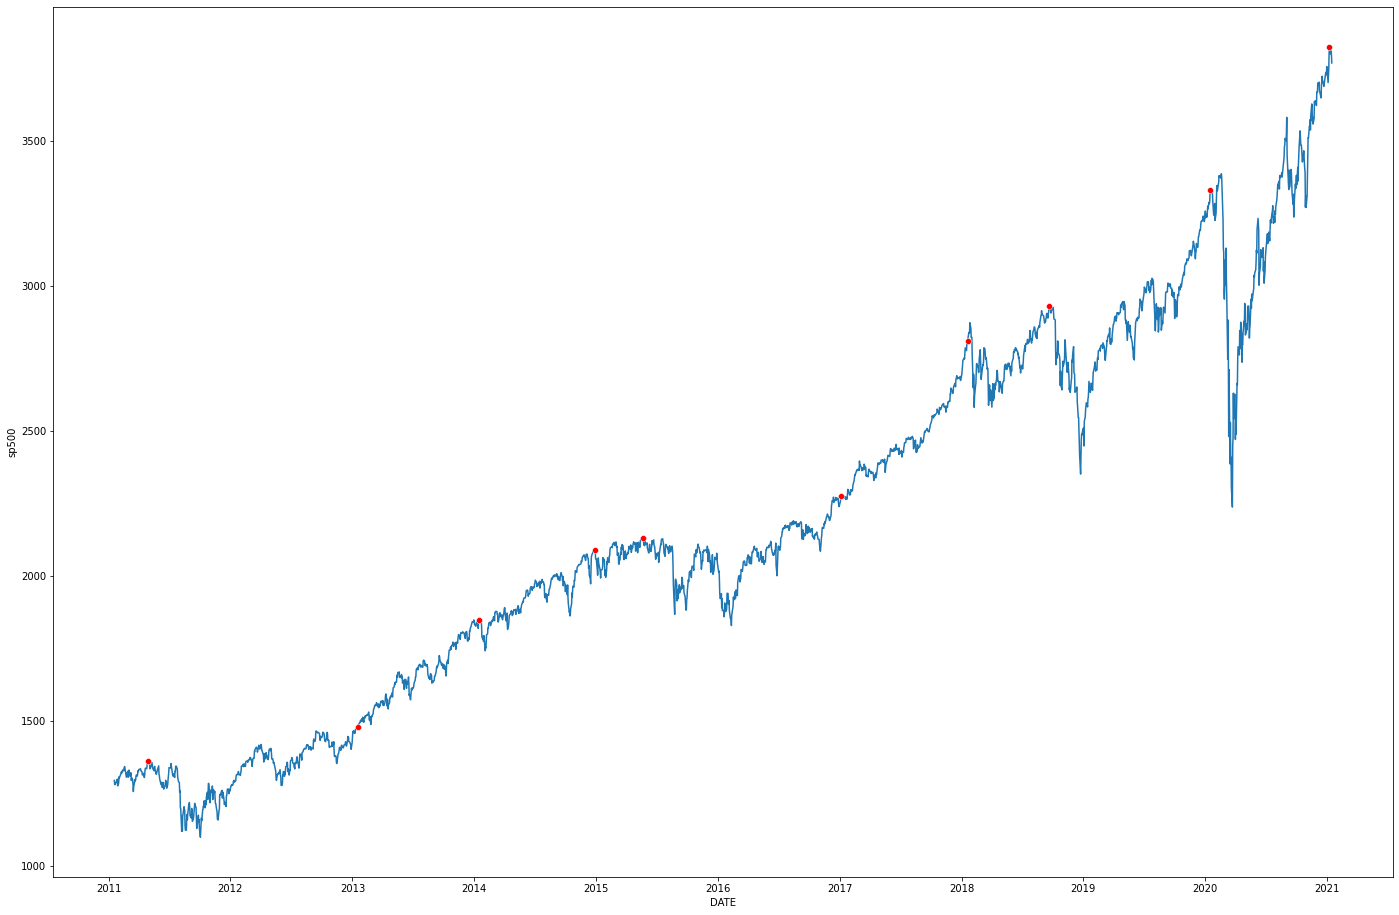

0.06634802308357357

In [12]:
annual_simulator.worst_return(plot=True)

In [13]:
annual_simulator.random_sampling_strategy(plot=False, sample=SIMULATION_SIZE)

0.15452924547205815

In [14]:
annual_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE)

0.15312756073669737

If you only buy once a year, then the timing can be really important. If you are a consistent pace buyer, then the return doesn't change whether you are monthly or annual buyer, the return is similar but the variability should be lower for monthly. However, if you are consistently good or bad, then your return can be as low as 6% or as high as 23%. 

**What this suggests is that if you are patient enough and wait for a crash every N years, then you can get be rewarded handsomly for your patience.**

## Weekly buyer

Finally, let us see what happens if we buy weekly.

In [15]:
weekly_simulator = SP500ReturnSimulator(series=sp500, number_of_purchase=520)

In [16]:
weekly_simulator.optimal_return()

0.16622309091716708

In [17]:
weekly_simulator.worst_return()

0.14892665989627263

In [18]:
weekly_simulator.random_sampling_strategy(plot=False, sample=SIMULATION_SIZE)

0.15705812716495382

In [19]:
weekly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE)

0.15707090941031743

If we are buying weekly, then there is very little value in trying to buy at the highest point. The gain is marginal and given the frequency of the purchase, the probability of correctly selecting the optimal point to buy for 520 times is astronomically small. The upside is that the worst you can do is also no far off compare to the best case scenario.

# bonus buying

Let's assume that we usually have some left over money to make additional purchases when required. We want to see whether if trying to buy at the low point would result in higher return.

To do this, we would need to create a weight vector based on our buy strategy (a limitation based on current code implementation).

In [20]:
len(weekly_simulator.split_series)

520

For the weekly simulator, we need to create a weight vector of length 520.

In [21]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<AxesSubplot:>

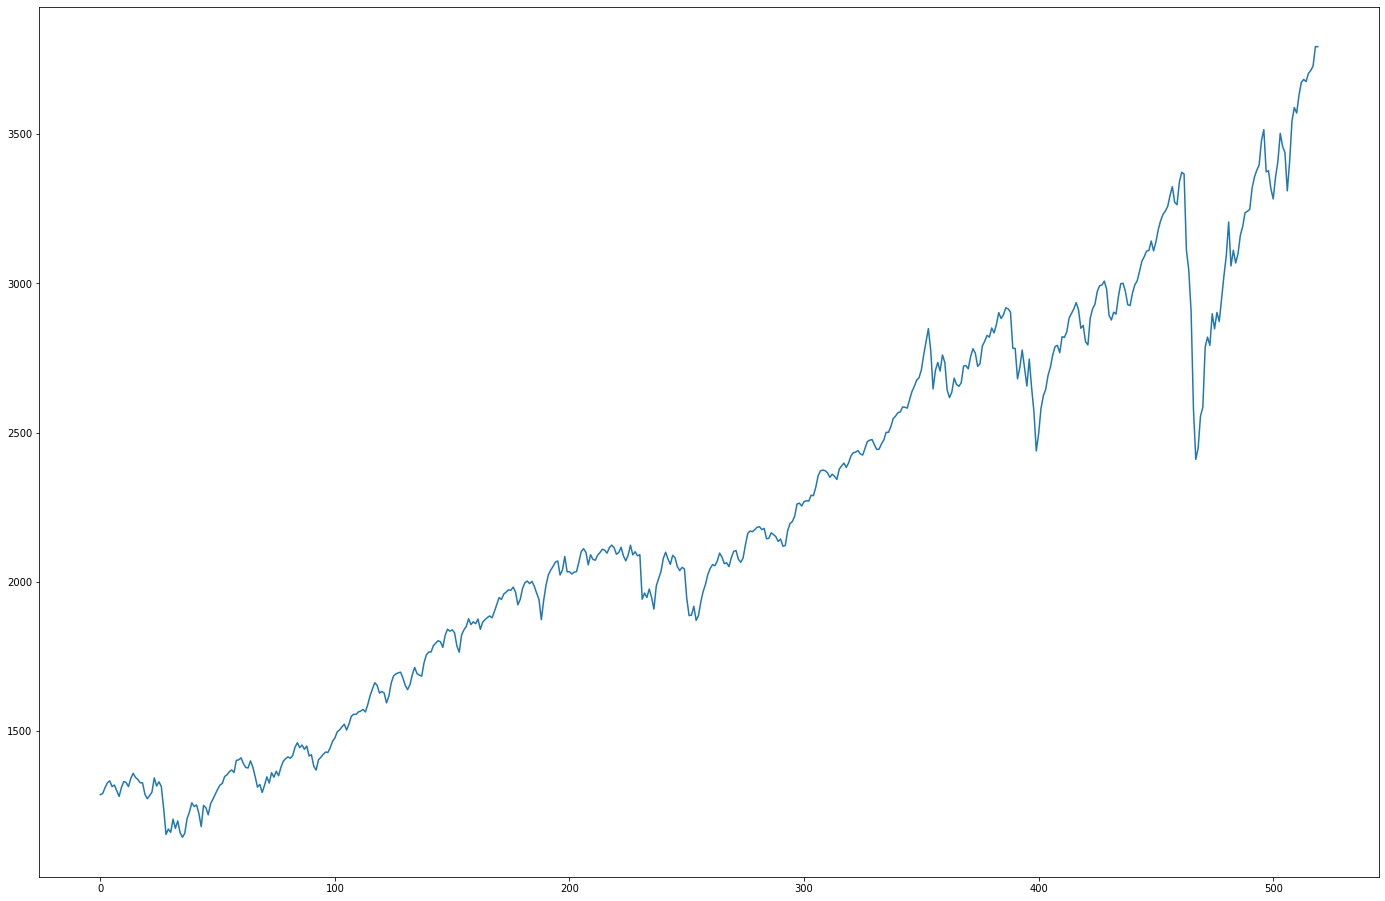

In [22]:
import numpy as np
import pandas as pd
average_series = [np.mean(i) for i in weekly_simulator.split_series]
pd.Series(average_series).plot()

In [23]:
bonus_buy_time = ((np.where((average_series[3:] - moving_average(average_series, 4)) < 0)[0]) + 4).tolist()

Let's assume a simple strategy where we purchae an additional 10% when the previous 4 period are all higher than the current period.

In [24]:
bonus_buy_time = ((np.where((average_series[3:]/moving_average(average_series, 4)) < 0.8)[0]) + 4).tolist()
len(bonus_buy_time)

0

In [25]:
buy_weight = pd.Series([1.1 if i in bonus_buy_time else 1 for i in range(weekly_simulator.number_of_purchase)])
normalised_buy_weight = buy_weight/buy_weight.sum()

In [26]:
bonus_buy_return = weekly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE, weights=normalised_buy_weight, average_simulation=False)

In [27]:
equal_weights = np.ones(weekly_simulator.number_of_purchase)
normalised_equal_weights = pd.Series(equal_weights/equal_weights.sum())
normal_buy_return = weekly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE, weights=normalised_equal_weights, average_simulation=False)

In [36]:
import scipy
scipy.stats.ttest_ind(normal_buy_return, bonus_buy_return, equal_var=True)

Ttest_indResult(statistic=0.18366697014432304, pvalue=0.8546542064237886)

As expected, there is no significant differences between the return based on this strategy. Let's reduce the buying frequency this to monthly.

In [37]:
monthly_simulator = SP500ReturnSimulator(series=sp500, number_of_purchase=120)

In [38]:
monthly_average_series = [np.mean(i) for i in monthly_simulator.split_series]
monthly_bonus_buy_time = ((np.where((monthly_average_series[3:] - moving_average(monthly_average_series, 4)) < 0)[0]) + 4).tolist()

In [40]:
monthly_buy_weight = pd.Series([1.1 if i in bonus_buy_time else 1 for i in range(monthly_simulator.number_of_purchase)])
normalised_monthly_buy_weight = monthly_buy_weight/monthly_buy_weight.sum()

In [42]:
monthly_bonus_buy_return = monthly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE, weights=normalised_monthly_buy_weight, average_simulation=False)

In [44]:
monthly_equal_weights = np.ones(monthly_simulator.number_of_purchase)
normalised_monthly_equal_weights = pd.Series(monthly_equal_weights/monthly_equal_weights.sum())
normal_monthly_buy_return = monthly_simulator.equal_space_strategy(plot=False, sample=SIMULATION_SIZE, weights=normalised_monthly_equal_weights, average_simulation=False)

In [45]:
scipy.stats.ttest_ind(normal_monthly_buy_return, monthly_bonus_buy_return, equal_var=True)

Ttest_indResult(statistic=-0.343888013549159, pvalue=0.7316672539703399)

In [46]:
np.mean(normal_monthly_buy_return)

0.15168249434283226

In [47]:
np.mean(monthly_bonus_buy_return)

0.15191164288214395

The difference is small as well for lower frequency purchases. Again, this shows that simple streategy like above/below movgin average doesn't provide benefit.